In [ ]:
# устанавливаем необходимые библиотеки
install.packages(c("readxl", "tidyverse", "lme4", "ggplot2"))

library(readxl)
library(tidyverse)
library(lme4)
library(ggplot2)

In [ ]:
install.packages("googledrive")
library(googledrive)

In [ ]:
drive_auth(use_oob = TRUE, cache = FALSE)

In [ ]:
drive_download("metadata.xlsx", overwrite = TRUE)

In [ ]:
meta <- read_xlsx("metadata.xlsx")

In [ ]:
# разобьём возраст на группы
meta$Age <- cut(meta$Age, breaks = c(40, 50, 60, 70, 80, 90),
                    labels = c("1", "2", "3", "4", "5"), include.lowest = TRUE)

# разобьём вес на группы
meta$Wt <- cut(meta$Wt, breaks = c(56, 63, 74, 83, 111),
                    labels = c("1", "2", "3", "4"), include.lowest = TRUE)

                    # разобьём вес на группы
meta$BMI <- cut(meta$BMI, breaks = c(21, 23, 27, 30, 38),
                    labels = c("1", "2", "3", "4"), include.lowest = TRUE)

In [ ]:
# Преобразование столбцов в фактор
meta$Age <- as.factor(meta$Age)
meta$Plaque <- as.factor(meta$Plaque)
meta$Sucrose <- as.factor(meta$Sucrose)
meta$Wt <- as.factor(meta$Wt)
meta$BMI <- as.factor(meta$BMI)
meta$Statins <- as.factor(meta$Statins)

In [ ]:
head(meta,3)

Vial number,Patient number,Sucrose,Name,Group,Date,Age,Plasma volume,Ht,Wt,⋯,r lat max,r ant max,r pos max,l lat max,l ant max,l pos max,carotid IMT mean,Plaque,Statins,comorbidities
<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dttm>,<fct>,<dbl>,<dbl>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>
1,50,0,"Woodard, Dillon",0,2022-03-26,3,6.5,163,4,⋯,0.65,0.80,0.80,0.81,0.78,0.80,0.6425,1,1,NA
2,51,0,"Kuck, Breanna",0,2023-12-23,1,5.5,179,4,⋯,1.03,0.92,1.03,1.03,1.03,1.09,0.8400,1,0,NA
3,52,0,"Thomas, Terrance",1,2022-10-10,2,7.0,164,3,⋯,1.00,0.90,0.95,0.85,0.90,0.90,0.8500,3,1,Type 2 diabetes mellitus; MI - 2016


1) **Logit regression**

In [ ]:
logit <- glm(Statins ~ `carotid IMT mean` + Choi...25 + Tgi...26 + HDLi...27 + LDLi...28, meta, family = binomial())


Call:
glm(formula = Statins ~ `carotid IMT mean` + Choi...25 + Tgi...26 + 
    HDLi...27 + LDLi...28, family = binomial(), data = meta)

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         5.457253   4.443019   1.228    0.219
`carotid IMT mean`  0.166486   3.271114   0.051    0.959
Choi...25          -0.045300   0.040310  -1.124    0.261
Tgi...26            0.008663   0.011734   0.738    0.460
HDLi...27           0.042324   0.054704   0.774    0.439
LDLi...28           0.005199   0.038492   0.135    0.893

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 50.016  on 37  degrees of freedom
Residual deviance: 36.396  on 32  degrees of freedom
AIC: 48.396

Number of Fisher Scoring iterations: 5


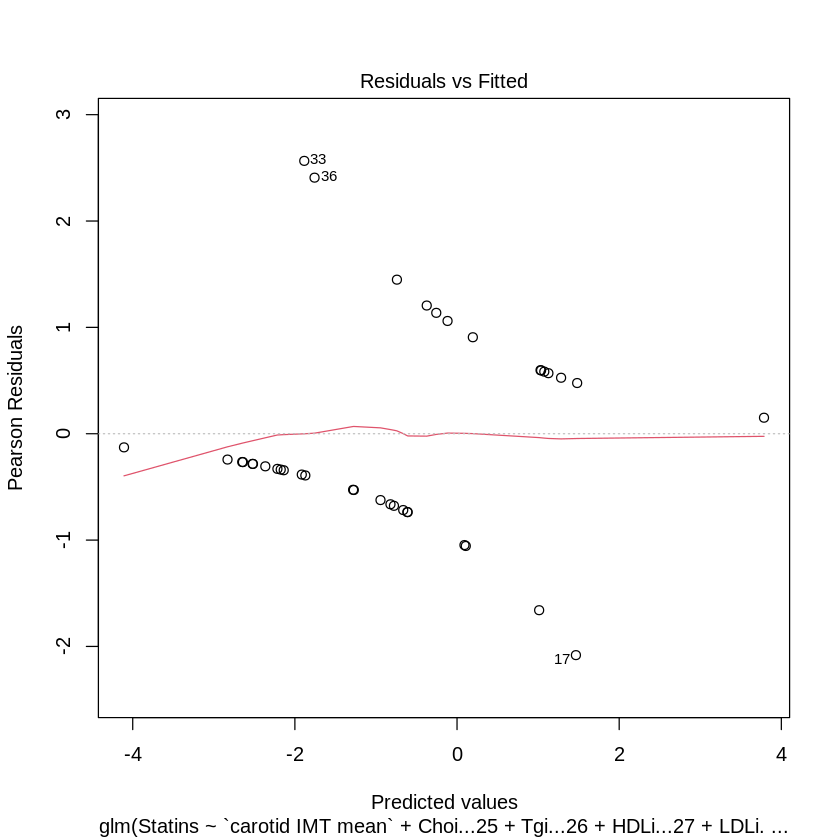

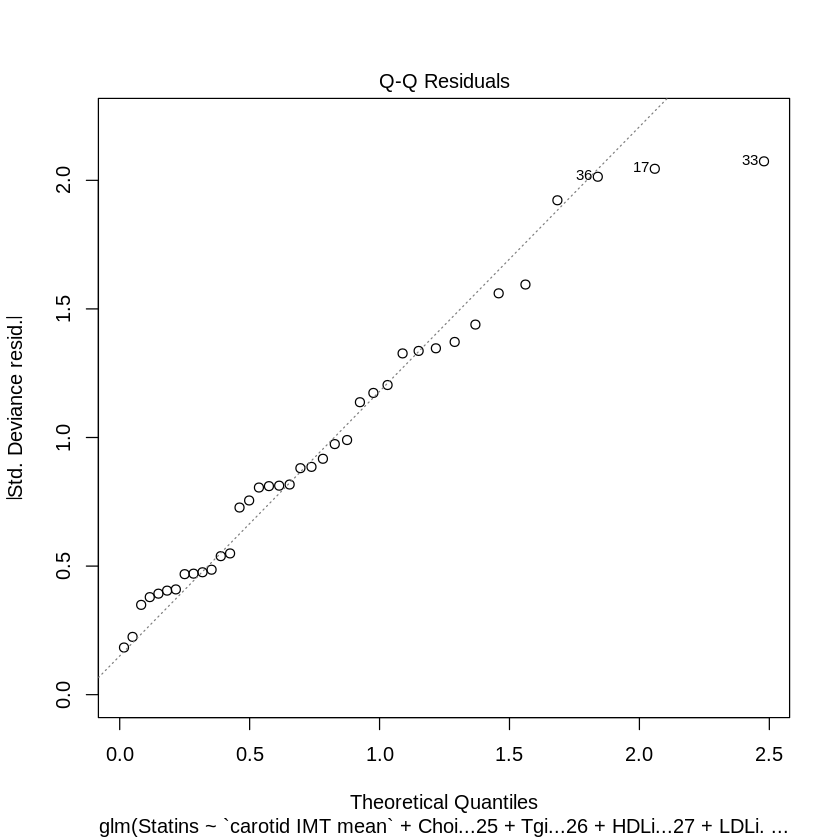

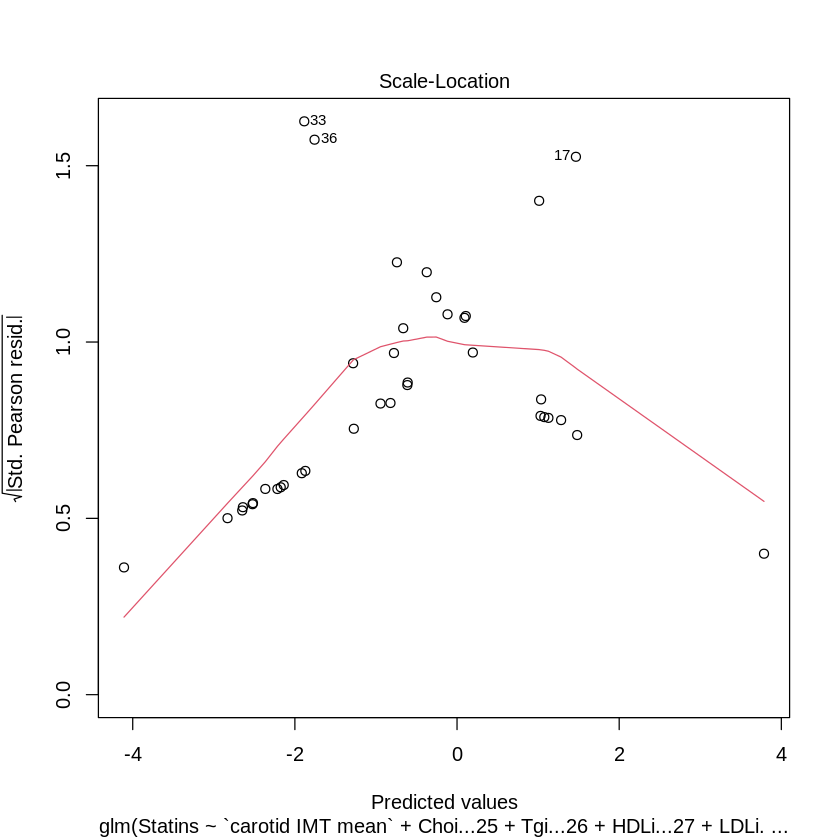

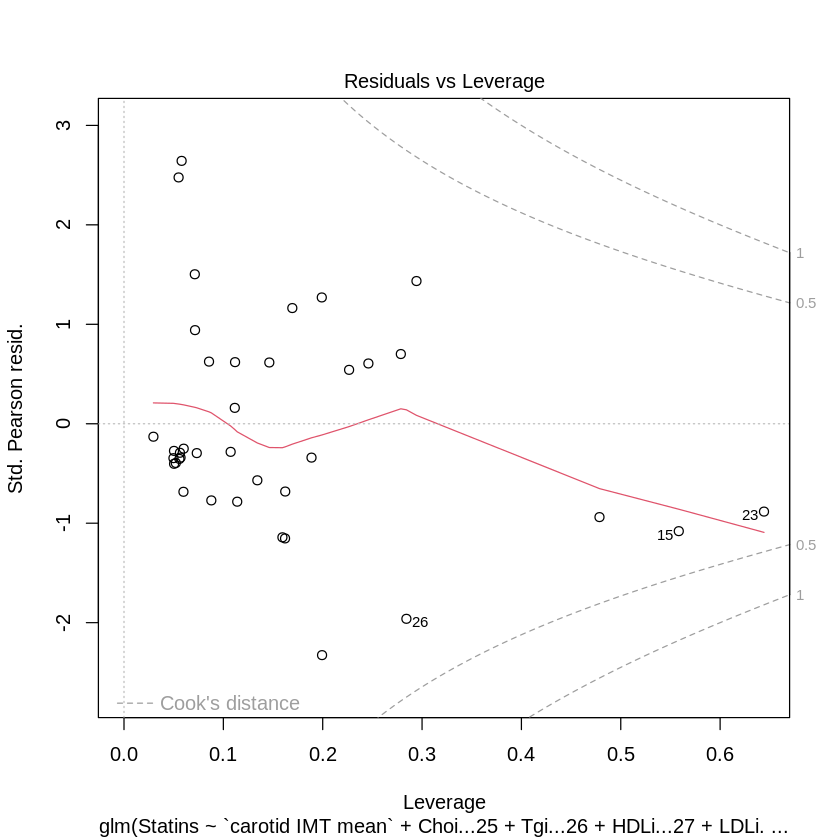

In [ ]:
summary(logit)
plot(logit)

In [ ]:
predictions <- predict(logit, newdata = meta, type = "response")
table(predictions > 0.5, meta$Statins)

       
         0  1
  FALSE 20  6
  TRUE   4  8

Результаты таблицы сопряженности показывают, что модель логистической регрессии справилась с классификацией наблюдений достаточно хорошо.

2) **Mixed effects model**

In [ ]:
model1 <- lmer(`carotid IMT mean` ~ AI + (1 | Age), data=meta)
model2 <- lmer(`carotid IMT mean` ~ AI + (AI | Age), data=meta)
model3 <- lmer(`carotid IMT mean` ~ AI + Group + (1 + AI + Group | Age), data=meta)
model4 <- lmer(`carotid IMT mean` ~ AI * Group + (1 + AI + Group | Age), data=meta)

In [ ]:
meta$predict_model1 <- predict(model1)
meta$predict_model2 <- predict(model2)
meta$predict_model3 <- predict(model3)
meta$predict_model4 <- predict(model4)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


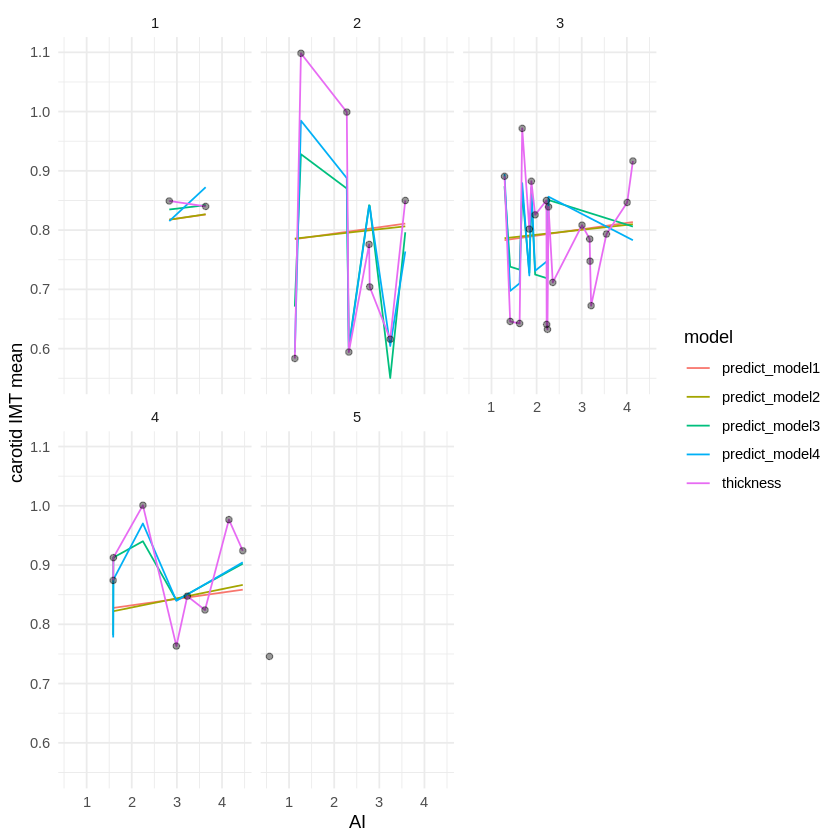

In [ ]:
meta %>%
  rename(thickness = `carotid IMT mean`) %>%
  pivot_longer(cols = c(thickness, predict_model1, predict_model2, predict_model3, predict_model4), names_to = "model", values_to = "carotid IMT mean") %>%
  ggplot(aes(x = AI, y = `carotid IMT mean`)) +
  geom_line(aes(colour = model)) +
  geom_point(data = meta, alpha = 0.4) +
  scale_x_continuous(breaks = 0:5) +
  facet_wrap(~Age) +
  theme_minimal()

In [ ]:
# 3 и 4 модели более точные

In [ ]:
anova(model1, model2, model3, model4)

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model1,4,-44.09011,-37.53977,26.04506,-52.09011,NA,NA,NA
model2,6,-40.11598,-30.29046,26.05799,-52.11598,0.02586855,2,0.987149013
model3,10,-48.34390,-31.96804,34.17195,-68.34390,16.22791689,4,0.002728096
model4,11,-49.56582,-31.55237,35.78291,-71.56582,3.22192292,1,0.072658230


3) **Probit regression**

In [ ]:
meta <- meta %>%
  mutate(`carotid IMT mean` = factor(case_when(`carotid IMT mean` <= 0.8 ~ '0',
                                               `carotid IMT mean` > 0.8 ~ '1')))

In [ ]:
probit <- glm(`carotid IMT mean` ~ AI + BMI, family = binomial(link = "probit"), data = meta)

summary(probit)


Call:
glm(formula = `carotid IMT mean` ~ AI + BMI, family = binomial(link = "probit"), 
    data = meta)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.5932     0.8500  -0.698    0.485
AI            0.4633     0.2996   1.547    0.122
BMI2         -0.7024     0.7465  -0.941    0.347
BMI3         -1.2251     0.7548  -1.623    0.105
BMI4          0.2393     0.7411   0.323    0.747

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 45.475  on 32  degrees of freedom
Residual deviance: 38.536  on 28  degrees of freedom
  (5 observations deleted due to missingness)
AIC: 48.536

Number of Fisher Scoring iterations: 5


In [ ]:
confint(probit)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-2.26200283,1.0442732
AI,-0.09415716,1.0856004
BMI2,-2.20711564,0.7204174
BMI3,-2.80917451,0.1892961
BMI4,-1.25244458,1.7112017


4) **Poisson regression**

In [ ]:
meta$numb <- sample(1:10, nrow(meta), replace = TRUE)

numb,mean_Sys
<int>,<dbl>
1,136.0000
2,125.7500
3,131.1429
4,134.1667
5,115.0000
6,131.0000
8,151.0000
9,134.0000
10,131.8750


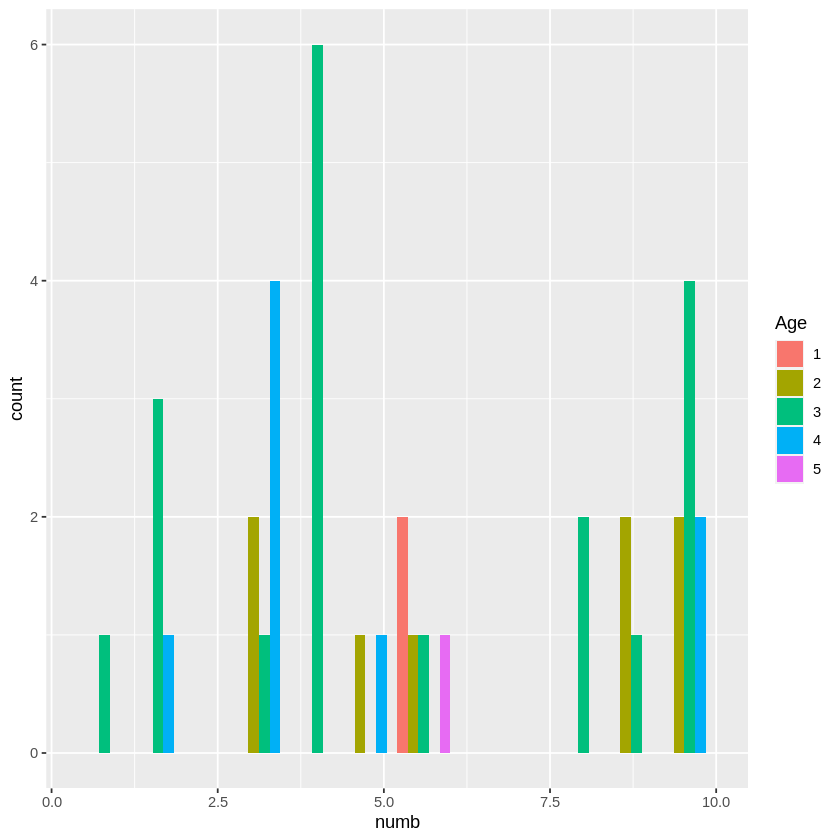

In [ ]:
meta %>%
  group_by(numb) %>%
  summarise(mean_Sys = mean(Sys))

ggplot(meta, aes(numb, fill = Age)) +
  geom_histogram(binwidth = .8, position = "dodge")


Call:
glm(formula = numb ~ Age + Sys, family = "poisson", data = meta)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  1.172943   0.655563   1.789   0.0736 .
Age2         0.170041   0.320163   0.531   0.5953  
Age3        -0.093705   0.304942  -0.307   0.7586  
Age4        -0.183813   0.330513  -0.556   0.5781  
Age5        -0.001541   0.500001  -0.003   0.9975  
Sys          0.004630   0.004398   1.053   0.2925  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 60.911  on 37  degrees of freedom
Residual deviance: 56.871  on 32  degrees of freedom
AIC: 200.41

Number of Fisher Scoring iterations: 5


Warning message:
“not plotting observations with leverage one:
  11”


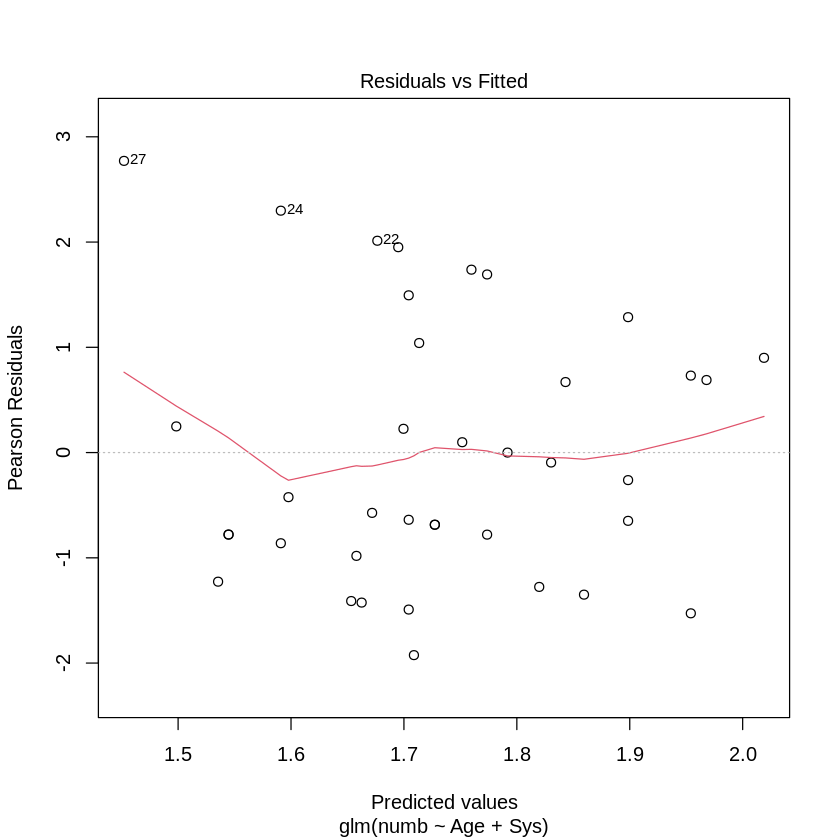

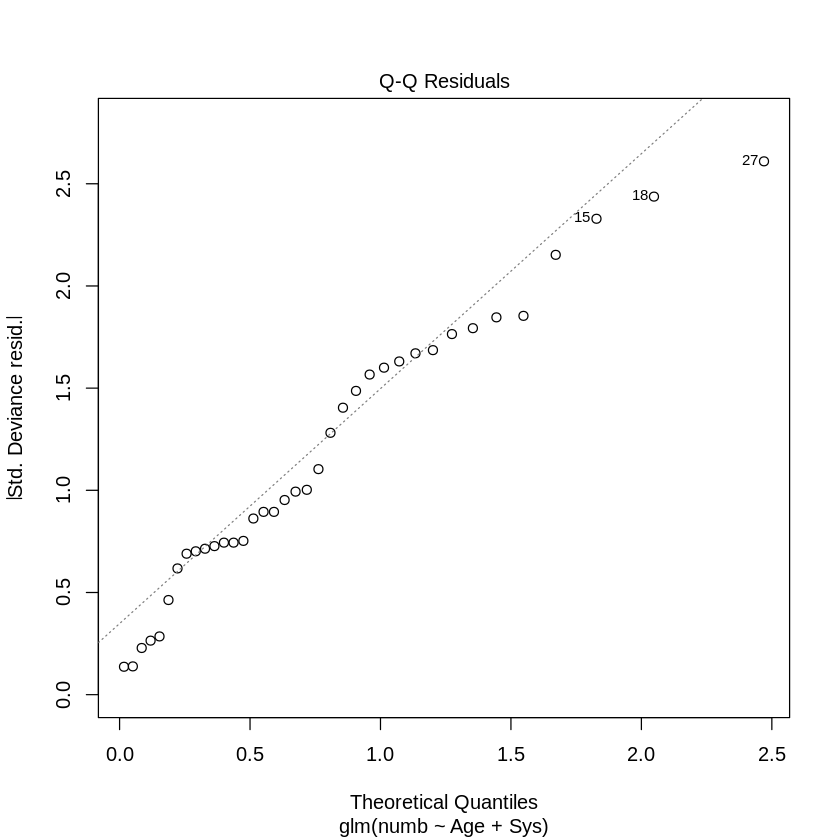

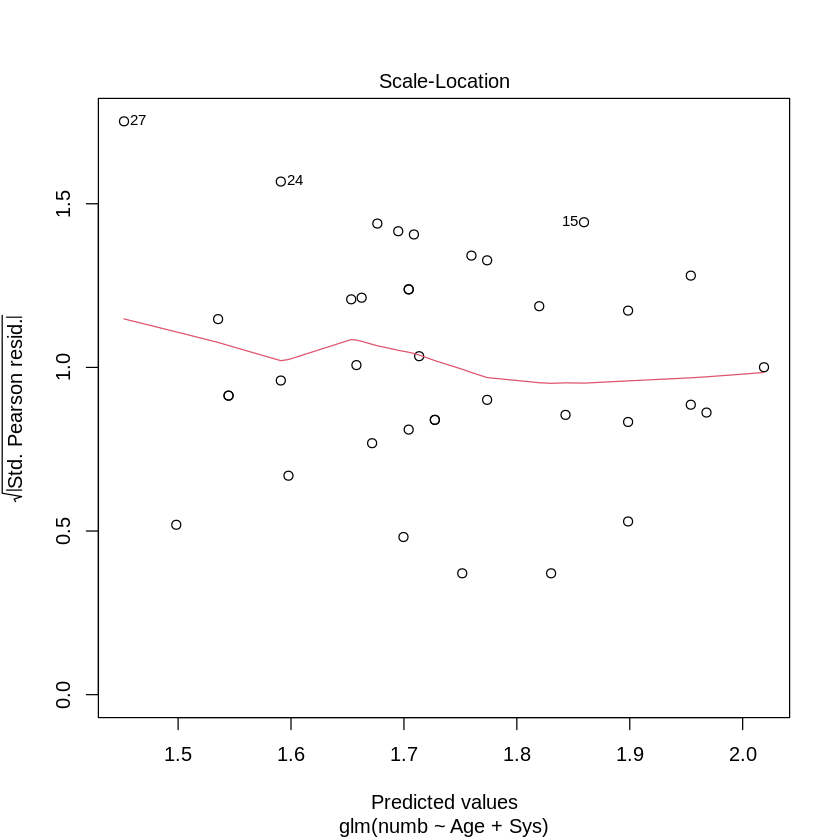

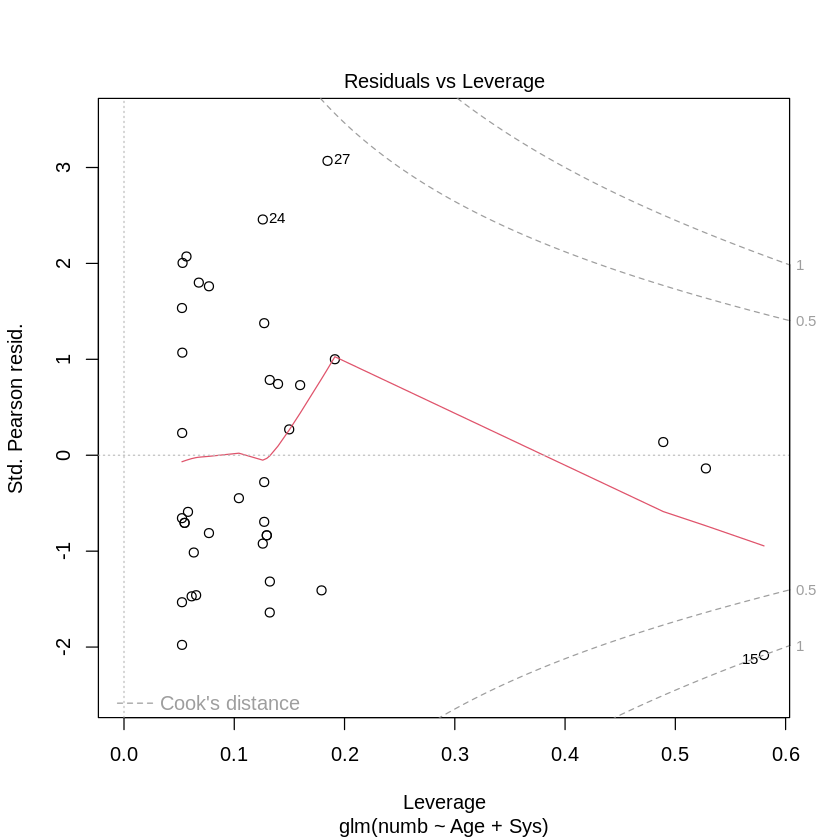

In [ ]:
poisson <- glm(numb ~ Age + Sys, family = "poisson" ,
             data = meta)

summary(poisson)
plot(poisson)

In [ ]:
pchisq(57, 32, lower.tail = FALSE)

[1] 0.00422393

In [ ]:
# 0.004 < 0.05 () данные не очень хорошо соотносятся с моделью.

In [ ]:
meta$pr_numb <- predict(poisson, type="response")

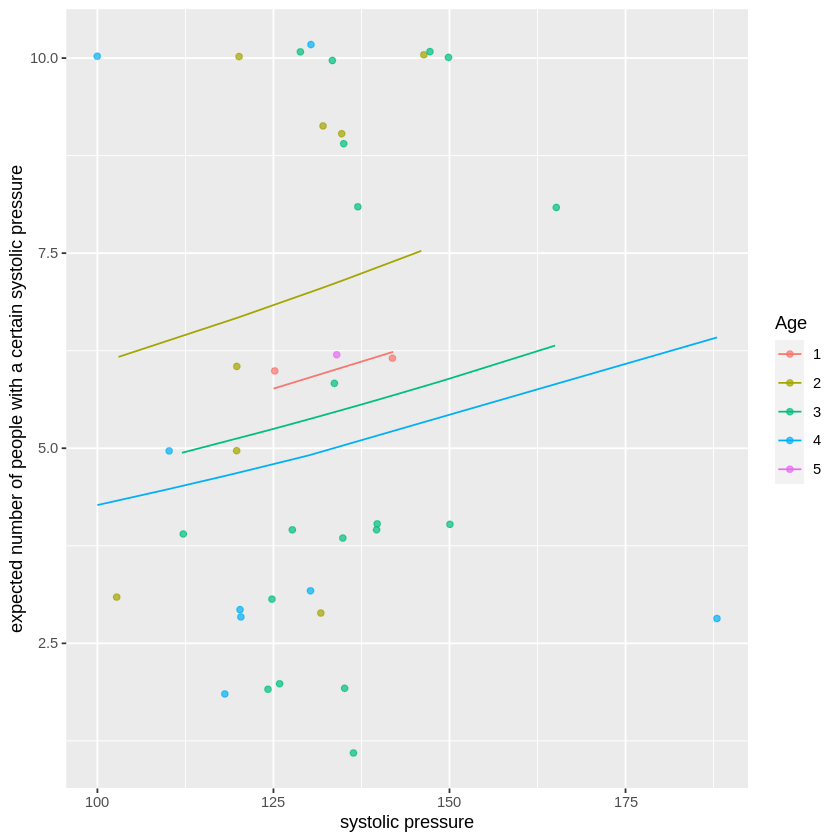

In [ ]:
ggplot(meta, aes(x = Sys, y = pr_numb, color = Age)) +
 geom_point(aes(y = numb), alpha = .7, position = position_jitter(h = .2)) +
 geom_line() +
 labs(x = "systolic pressure", y = "expected number of people with a certain systolic pressure")